<a href="https://colab.research.google.com/github/ritwiks9635/CNN_Project_File/blob/main/Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **https://www.katnoria.com/siamese-one-shot/**

In [ ]:
! unzip /content/https:/www.kaggle.com/datasets/mbkinaci/image-localization-dataset/image-localization-dataset.zip

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as xt
import plotly.express as px
import matplotlib.pyplot as plt


from PIL import Image
from skimage import io
from glob import glob
from tensorflow.keras.models import Model
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [4]:
xml_example = "/content/training_images/cucumber_10.xml"

with open(xml_example,  "r") as f:
  data = f.read()
  content = BeautifulSoup(data, "xml")

content

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>single cucumber</folder>
<filename>cucumber_10.jpg</filename>
<path>C:\Users\Muhammed Buyukkinaci\Downloads\single cucumber\cucumber_10.jpg</path>
<source>
<database>Unknown</database>
</source>
<size>
<width>227</width>
<height>227</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>cucumber</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>13</xmin>
<ymin>70</ymin>
<xmax>219</xmax>
<ymax>160</ymax>
</bndbox>
</object>
</annotation>

In [5]:
xml_path = sorted(glob("/content/training_images/*.xml"))
#len(xml_path)

y = []
for files in xml_path:
  label = 0
  info = xt.parse(files)
  root = info.getroot()
  obj = root.find("object")

  label_obj = (obj.find("name").text)

  if "cucumber" in label_obj:
    label = 1
  elif "eggplant" in label_obj:
    label = 2
  elif "mushroom" in label_obj:
    label = 3

  bbox = obj.find("bndbox")

  xmin = (bbox.find("xmin").text)
  ymin = (bbox.find("ymin").text)
  xmax = (bbox.find("xmax").text)
  ymax = (bbox.find("ymax").text)

  y.append([int(label), int(xmin), int(ymin), int(xmax), int(ymax)])

In [6]:
y[0]

[1, 23, 42, 206, 199]

In [7]:
X = []
img_path = sorted(glob("/content/training_images/*.jpg"))

for imgs in img_path:
  img = cv2.imread(imgs, cv2.COLOR_BGR2RGB)
  X.append(img)

In [8]:
img_example = X[0]
bbox = y[0][1:]

In [9]:
y[0][1:]

[23, 42, 206, 199]

In [10]:
fig = px.imshow(img_example)
fig.update_layout(width=800, height=600, margin=dict(l=10, r=10, b=10, t=10))
fig.add_shape(type='rect',x0=bbox[0], x1=bbox[2], y0=bbox[1], y1=bbox[3], xref='x', yref='y',line_color='cyan')

In [11]:
X = np.array(X)
y = np.array(y)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
categ_train = y_train[:,0:1]
categ_test = y_test[:,0:1]
bbox_train = y_train[:,1:]
bbox_test = y_test[:,1:]
categ_train.shape, categ_test.shape, bbox_train.shape, bbox_test.shape

((148, 1), (38, 1), (148, 4), (38, 4))

In [14]:
categ_train = tf.keras.utils.to_categorical(categ_train)
categ_test = tf.keras.utils.to_categorical(categ_test)

In [ ]:
categ_train

In [16]:
base_model = tf.keras.applications.InceptionV3(weights = "imagenet", input_shape = (227, 227, 3), include_top=False)

87910968/87910968 [==============================] - 4s 0us/step


In [17]:
base_model.trainable = True

last_layer = base_model.get_layer("mixed10")

last_output = last_layer.output

In [18]:
x = Flatten()(last_output)
x1 = Dropout(0.3)(x)
x2 = Dense(4112,activation="relu")(x1)
drop1 = Dropout(0.3)(x2)
x3 = Dense(1028,activation="relu")(x2)
x4 = Dense(1028,activation="relu")(x3)
drop1 = Dropout(0.5)(x4)

x5 = Dense(256,activation="relu")(drop1)
drop2 = Dropout(0.3)(x5)
classification_output = Dense(4,activation='softmax',name = 'classification')(x2)
bounding_box_output = Dense(4,name = 'bounding_box')(x5)
model = tf.keras.Model(inputs = base_model.inputs, outputs = [classification_output, bounding_box_output])

In [19]:
def scheduler(epoch, lr):
    """
    Applies exponential decay
    Args:
    epoch: Epoch to start the decay at
    lr: current learning rate
    """
    if epoch < 40:
        return lr
    else:
        return lr * tf.math.exp(-0.12)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [20]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss = {'classification' : 'categorical_crossentropy',
                      'bounding_box' : 'mse'},
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : 'mse'})

In [21]:
history = model.fit(x_train, [categ_train,bbox_train],epochs=70,validation_data=(x_test,[categ_test,bbox_test]),callbacks=[callback])

Epoch 1/70
5/5 [==============================] - 66s 2s/step - loss: 15775.1465 - classification_loss: 1.9490 - bounding_box_loss: 15773.1973 - classification_accuracy: 0.3108 - bounding_box_mse: 15773.1973 - val_loss: 986.9760 - val_classification_loss: 2.0989 - val_bounding_box_loss: 984.8771 - val_classification_accuracy: 0.3684 - val_bounding_box_mse: 984.8771 - lr: 1.0000e-04
Epoch 2/70
5/5 [==============================] - 1s 298ms/step - loss: 3163.5320 - classification_loss: 1.3779 - bounding_box_loss: 3162.1541 - classification_accuracy: 0.3716 - bounding_box_mse: 3162.1541 - val_loss: 35246.7969 - val_classification_loss: 1.8318 - val_bounding_box_loss: 35244.9688 - val_classification_accuracy: 0.4737 - val_bounding_box_mse: 35244.9688 - lr: 1.0000e-04
Epoch 3/70
5/5 [==============================] - 2s 310ms/step - loss: 3464.7927 - classification_loss: 1.2352 - bounding_box_loss: 3463.5574 - classification_accuracy: 0.4122 - bounding_box_mse: 3463.5574 - val_loss: 4055.8

In [22]:
evaluate = pd.DataFrame(history.history)
evaluate.head()

,loss,classification_loss,bounding_box_loss,classification_accuracy,bounding_box_mse,val_loss,val_classification_loss,val_bounding_box_loss,val_classification_accuracy,val_bounding_box_mse,lr
0,15775.146484,1.949016,15773.197266,0.310811,15773.197266,986.975952,2.098863,984.877075,0.368421,984.877075,0.0001
1,3163.531982,1.377887,3162.154053,0.371622,3162.154053,35246.796875,1.831760,35244.968750,0.473684,35244.968750,0.0001
2,3464.792725,1.235160,3463.557373,0.412162,3463.557373,4055.823486,1.429876,4054.393799,0.157895,4054.393799,0.0001
3,2177.267822,1.181482,2176.085938,0.378378,2176.085938,1431.263916,1.917210,1429.346680,0.368421,1429.346680,0.0001
4,1629.902710,1.070818,1628.831787,0.520270,1628.831787,7151.841309,1.577459,7150.264160,0.289474,7150.264160,0.0001


In [23]:
fig = px.line(evaluate,y=[evaluate['classification_loss'],evaluate['val_classification_loss']],template="seaborn",color_discrete_sequence=['#05445E','#75E6DA'])
fig.update_layout(
    title_font_color="#75E6DA",
    xaxis=dict(color="#75E6DA",title='Epochs'),
    yaxis=dict(color="#75E6DA")
 )
fig.show()

In [24]:
fig = px.line(evaluate,y=[evaluate['classification_accuracy'],evaluate['val_classification_accuracy']],template="seaborn",color_discrete_sequence=['#05445E','#75E6DA'])
fig.update_layout(
    title_font_color="#75E6DA",
    xaxis=dict(color="#75E6DA",title='Epochs'),
    yaxis=dict(color="#75E6DA")
 )
fig.show()

In [25]:
def predict(path, model, from_url=False):
    """
    passes an image to a trained model and returns annotated image

    Args:
    path:  path containing the image or a list of paths
    model:  pretrained model instance
    from_url: (boolen) to check if the path is a url
    """
    # Check if the path is a list
    if type(path) == list:
        # loop over each path and read the image
        for p in path:
            if from_url:
                image = io.imread(p)
            else:
                image = cv2.imread(p)
    # Check if the type of the path is a string
    elif type(path) == str:
            # read the given image
            if from_url:
                image = io.imread(path)
            else:
                image = cv2.imread(path)
    # Resize the image into the appropriate shape
    image = cv2.resize(image,(227,227))
    # get model predictions
    categ,bbox = model.predict(np.array([image]))
    # Get class of the highest given probability
    categ = np.argmax(categ)
    # flatten the bounding box array and cast it into integer
    bbox = bbox.flatten()
    bbox = bbox.astype(int)
    # draw a rectangle on the image using the predicted bbox coordinates
    image = cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(255,0,0),1)
    # set prediction class to an empty string
    prediction = ''
    # set the prediction to the name of the given class according to the model's prediction
    if categ == 1:
        prediction = 'Cucumber'
    elif categ == 2:
        prediction = 'Egg Plant'
    elif categ == 3:
        prediction = 'Mushroom'
    # Put the text of the prediction on the image
    final_img = cv2.putText(image,prediction,(bbox[0],bbox[1]-4),cv2.FONT_HERSHEY_SIMPLEX,0.3,(255,0,0),1,255)
    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(final_img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 2s 2s/step


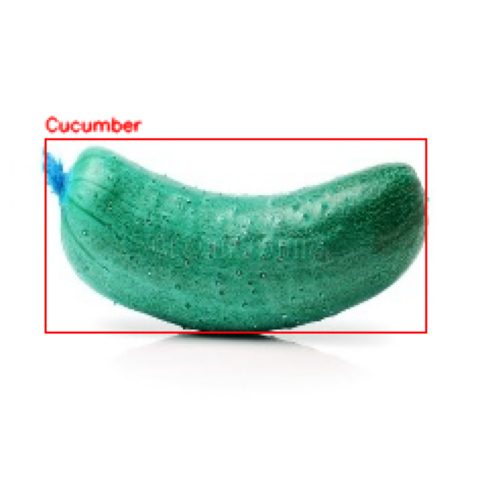

1/1 [==============================] - 0s 26ms/step


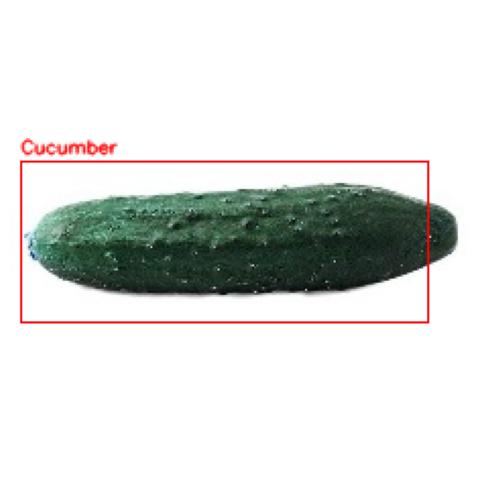

1/1 [==============================] - 0s 40ms/step


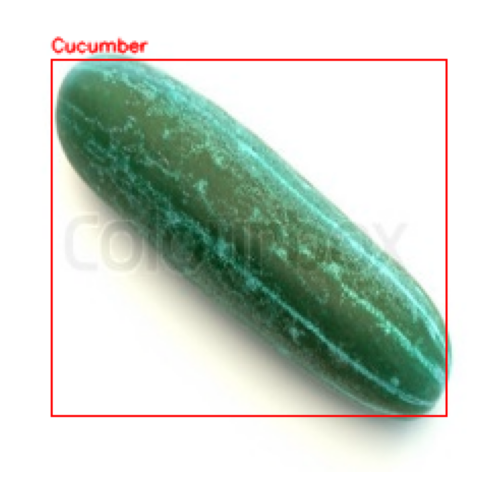

1/1 [==============================] - 0s 28ms/step


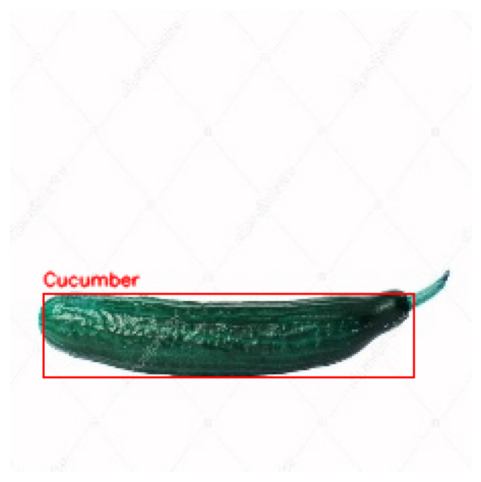

1/1 [==============================] - 0s 27ms/step


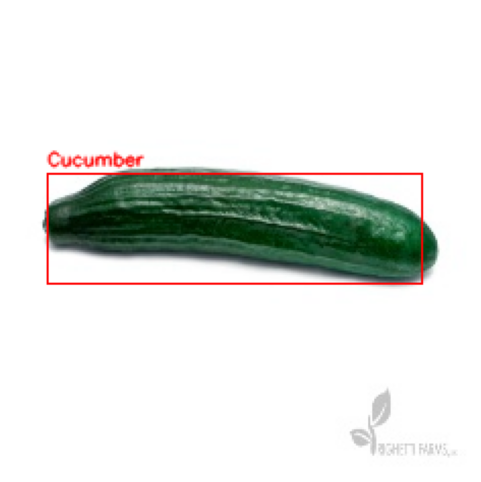

1/1 [==============================] - 0s 26ms/step


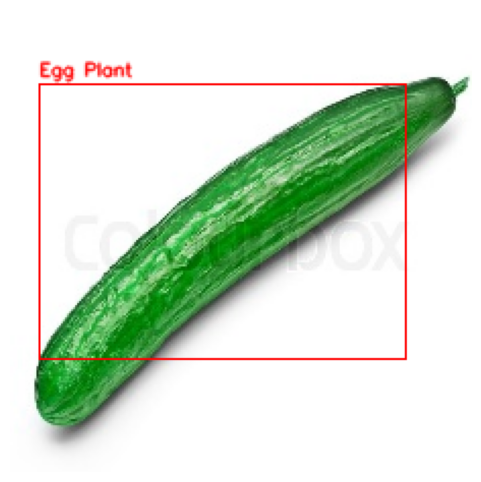

In [26]:
for i in range(40,46):
    paths = []
    paths.append(f'/content/training_images/training_images/cucumber_{i}.jpg')
    predict(paths,model,False)

1/1 [==============================] - 0s 70ms/step


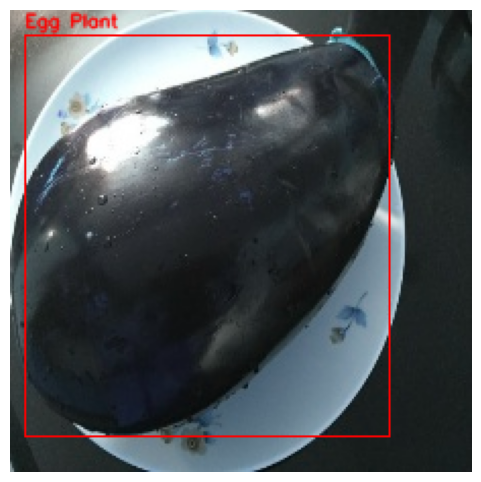

1/1 [==============================] - 0s 41ms/step


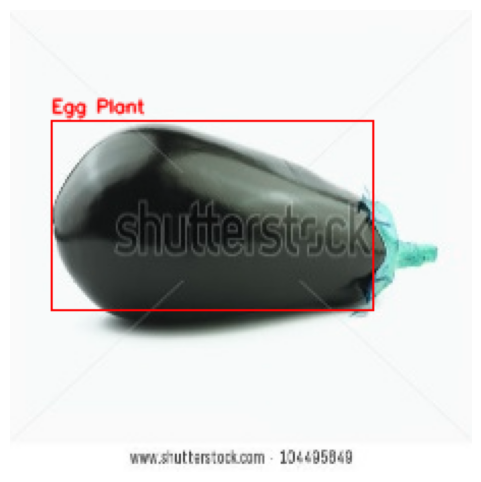

1/1 [==============================] - 0s 39ms/step


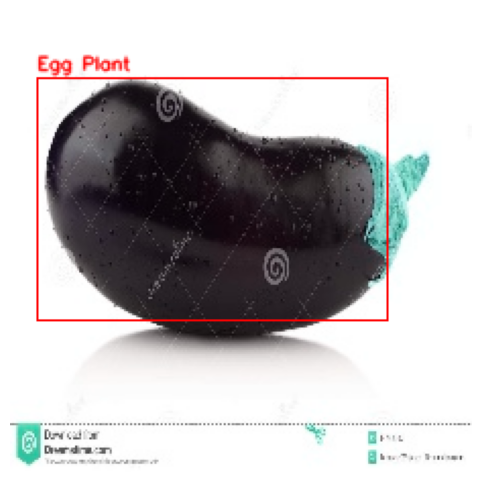

1/1 [==============================] - 0s 39ms/step


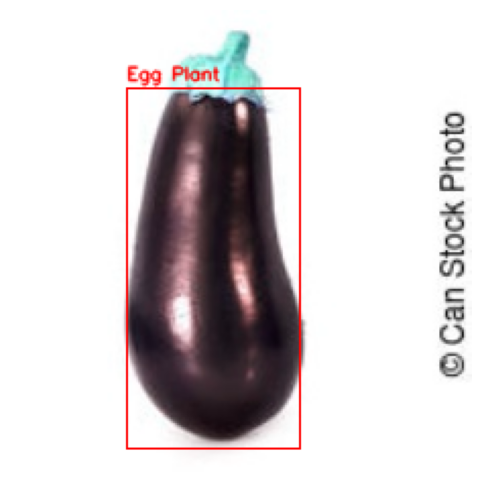

1/1 [==============================] - 0s 45ms/step


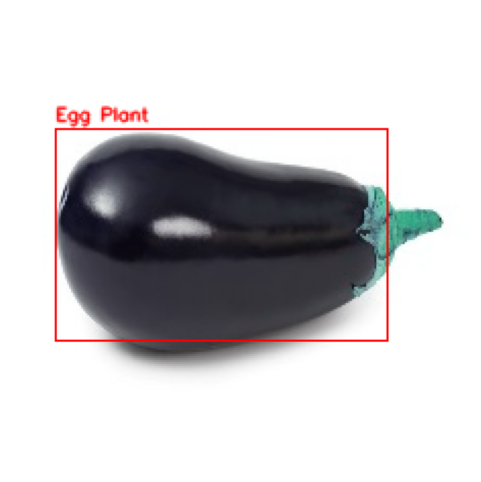

1/1 [==============================] - 0s 42ms/step


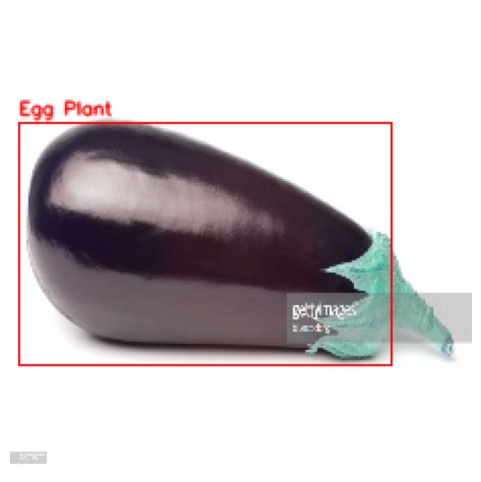

In [27]:
for i in range(40,46):
    paths = []
    paths.append(f'/content/training_images/training_images/eggplant_{i}.jpg')
    predict(paths,model,False)

1/1 [==============================] - 0s 42ms/step


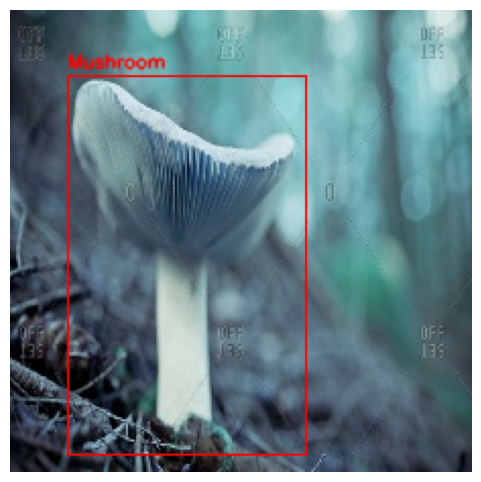

1/1 [==============================] - 0s 59ms/step


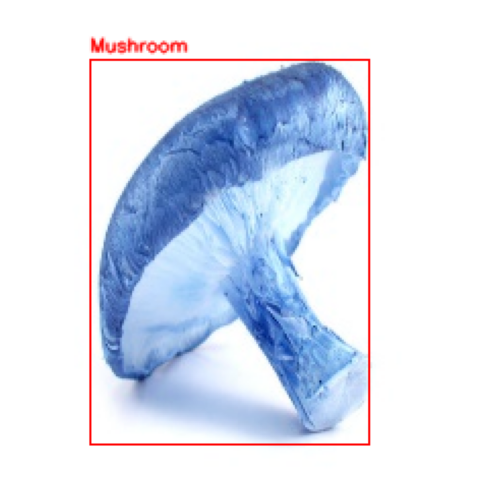

1/1 [==============================] - 0s 56ms/step


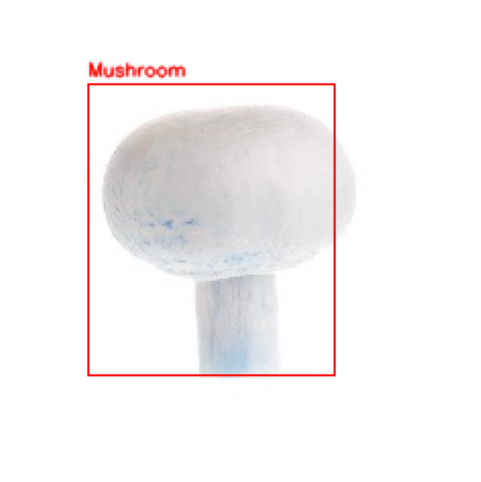

1/1 [==============================] - 0s 28ms/step


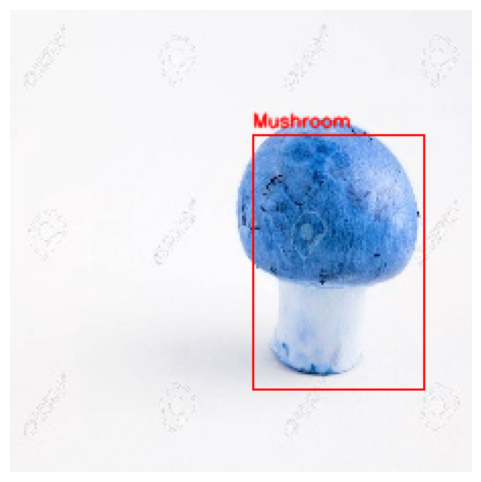

1/1 [==============================] - 0s 28ms/step


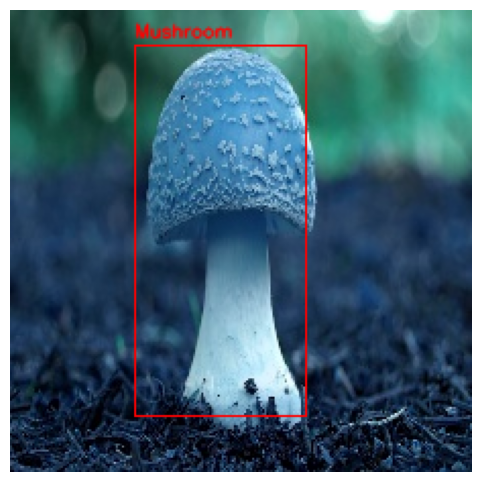

1/1 [==============================] - 0s 58ms/step


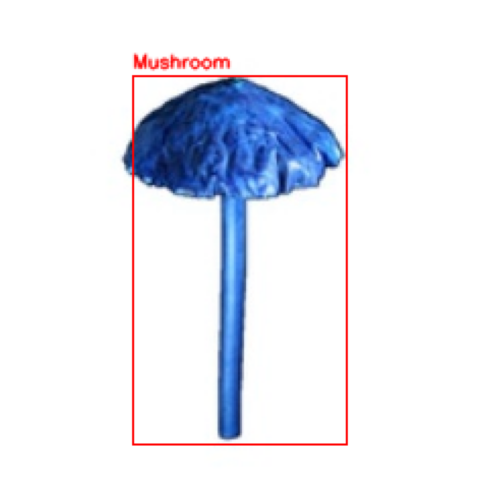

In [28]:
for i in range(40,46):
    paths = []
    paths.append(f'/content/training_images/training_images/mushroom_{i}.jpg')
    predict(paths,model,False)